In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings
import seaborn as sns
from scipy.optimize import minimize
import copy

<h1>Hyperparameters<h1>


In [212]:
K = 5 # validation folds
MIN_LAG = 120
MAX_LAG = 168
SEED = 42
VAL_SPLIT = 0.15

In [213]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [214]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [215]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DFS_orig = copy.deepcopy(DFS)
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs
for i in range(len(DFS)):
    DFS[i].index = pd.to_datetime(DFS[i].index)
DFS_orig = copy.deepcopy(DFS)

In [216]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [217]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<h1>Training<h1>

In [218]:
# k-Fold for validation
k = K
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [224]:
def soft_abs(z,eps):
    return np.sqrt(z**2+eps)

In [220]:

def cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac):
    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
    
        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+MAPEfac))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+MAPEfac)
    mape_values = []
    L = len(data)
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[offset:int(offset + np.floor(L/k))]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        
        tol = 1e-4
        n_features = X_train.shape[1]
        w_optimal_1 = np.random.randn(n_features)/initVarianceFac # Random initialize
        w_optimal_2 = np.random.randn(n_features)/initVarianceFac # Random initialize
        for i in range(2):
            w_initial1 = np.where(w_optimal_1>10**(-2),w_optimal_1,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
            w_initial2 = np.where(w_optimal_2>10**(-2),w_optimal_2,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
            result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, alpha1), method='L-BFGS-B', options={'tol':tol})
            w_optimal_1 = result.x
            result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, alpha2), method='L-BFGS-B', options={'tol':tol})
            w_optimal_2 = result.x

        y1_pred = X_val @ w_optimal_1
        y2_pred = X_val @ w_optimal_2

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
    return average_mape

Oslo


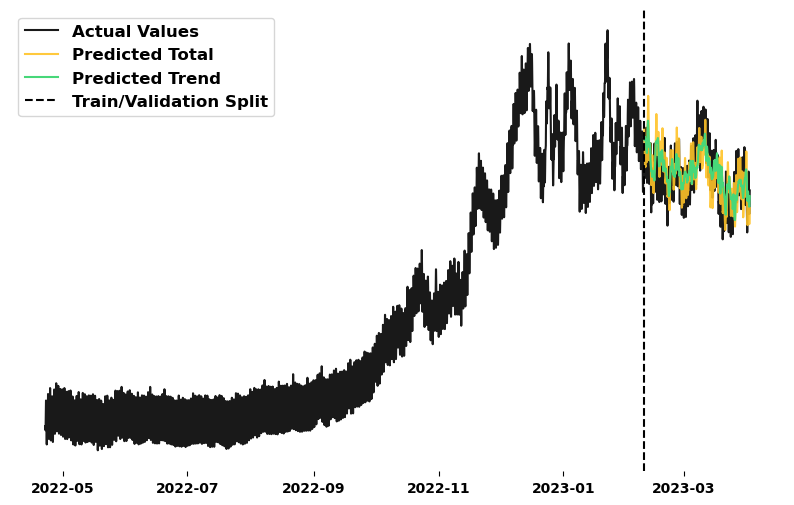

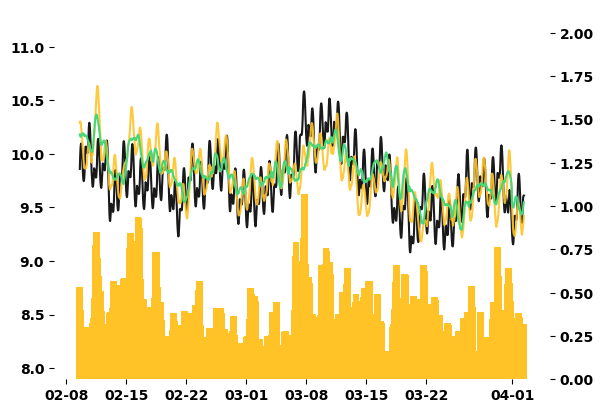

Error95: 0.04369154901707646
Out of sample MAPE: 1.9253289262692492
Mean oveprediction: 2.0901122980316464
Mean underprediction: 1.705101525286045
MAPE with trend prediction only: 2.0841964899286896
Coefficients: 
is_holiday: -0.13145029521421817
is_weekend: 0.13974825713651493
hour: 0.23833874735810248
month: 0.1344027975535727
temperature_trend: -0.07102970508841684
temperature_seasonal: 0.16889315489739104
spot_price_trend: -0.06951533446459993
spot_price_seasonal: 0.0323754176536527
temperature_trend_L24: -0.11660424044723564
temperature_trend_L25: 0.14745447861649777
temperature_trend_L26: -0.17809047668945233
temperature_trend_L27: -0.036597770321951176
temperature_trend_L28: 0.021536037068258504
temperature_trend_L29: -0.13064460531285307
temperature_trend_L30: -0.12175523633002934
temperature_trend_L31: -0.061277672937010176
temperature_trend_L32: -0.04643428547060421
temperature_trend_L33: 0.04439856475346466
temperature_trend_L34: -0.05244174982281975
temperature_trend_L35: -

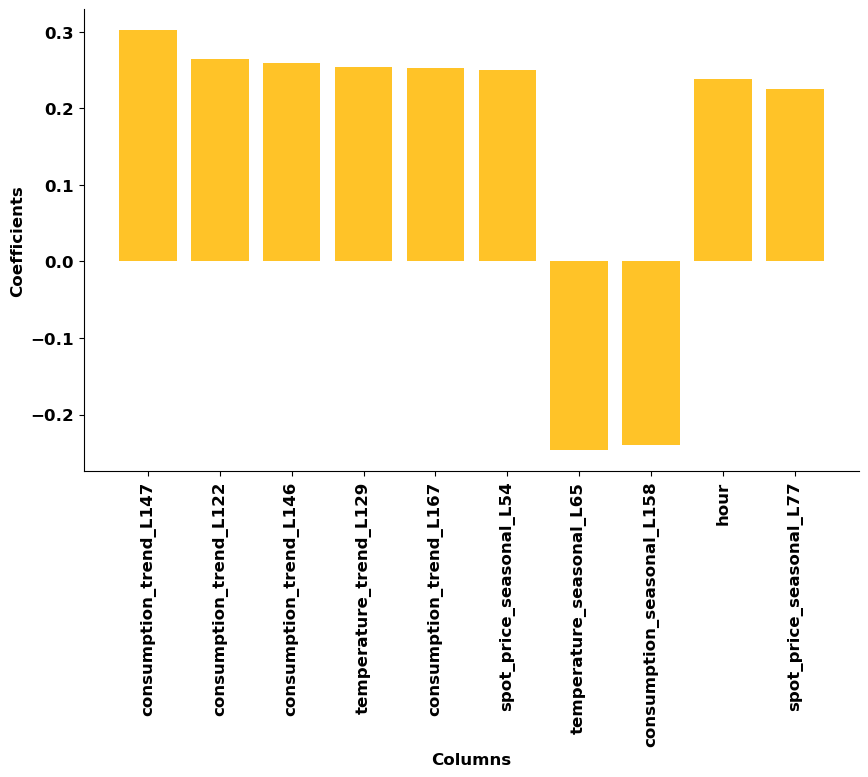

Stavanger


KeyboardInterrupt: 

In [229]:
all_models = []
CV = False
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    #alpha1s = [2**(-20),2**(-18)]
    #alpha2s = [2**(-12), 2**(-11), 2**(-10)]
    #MAPEfacs = [0.1, 1, 10, 100]
    alpha1s = [2**(-18), 2**(-16)]
    alpha2s = [2**(-10), 2**(-16)]
    MAPEfacs = [10]
    initVarianceFacs = [50,75]

    alpha1smanual = [2**(-16),2**(-18),2**(-18),2**(-18),2**(-18)]
    alpha2smanual = [2**(-16),2**(-16),2**(-10),2**(-16),2**(-10)]
    MAPEfacsmanual = [10,10,10,10,10]
    initVarianceFacsmanual = [75,75,75,75,75]

    if CV:
        # Grid Search
        best_mape = float('inf')
        best_hyperparams = None

        print("Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE")
        for alpha1 in alpha1s:
            for alpha2 in alpha2s:
                for MAPEfac in MAPEfacs:
                    for initVarianceFac in initVarianceFacs:
                        average_mape = cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac)
                        print(f"{alpha1} {alpha2} {MAPEfac} {initVarianceFac} --> {average_mape}")
                        # Update best hyperparameters if current MAPE is lower
                        if average_mape < best_mape:
                            best_mape = average_mape
                            best_hyperparams = (alpha1,alpha2,MAPEfac,initVarianceFac)

        print(f'Best Hyperparameters: {best_hyperparams}')
        print(f'Best CV MAPE: {best_mape}%')
    else:
        best_hyperparams = (alpha1smanual[I],alpha2smanual[I],MAPEfacsmanual[I],initVarianceFacsmanual[I])

    tol = 1e-4
    X = data
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
    y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
    y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
        F = 25
        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+best_hyperparams[2]),F)) + alpha * (np.sum(soft_abs(w,2**(-30)))/np.mean(y_true+best_hyperparams[2])+np.sqrt(F))

    n_features = X_train.shape[1]
    
    w_initial1 = np.random.randn(n_features)/best_hyperparams[3] # Set small coefficients to zero, add noise 
    w_initial2 = np.random.randn(n_features)/best_hyperparams[3] # Set small coefficients to zero, add noise 
    result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, best_hyperparams[0]), method='L-BFGS-B', options={'tol':tol})
    w_optimal_1 = result.x
    result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, best_hyperparams[1]), method='L-BFGS-B', options={'tol':tol})
    w_optimal_2 = result.x

    y1_pred = X_val @ w_optimal_1
    y2_pred = X_val @ w_optimal_2
    all_models.append([w_optimal_1, w_optimal_2])

    train_pred1 = X_train @ w_optimal_1
    train_pred2 = X_train @ w_optimal_2

    actual = (y1 + y2)
    full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    # Create an array of indices for plotting
    xs = X.index
    xs_train = X_train.index
    xs_oos = X_val.index

    # Plot actual values and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(xs, (actual) * sig + mu, label='Actual Values', color='black', alpha=0.9)
    #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
    plt.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
    plt.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='#47D779')
    plt.axvline(xs[len(train_pred1)], linestyle='--', color='black', label='Train/Validation Split')
    #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #plt.xlabel('Time')
    plt.xticks(fontweight='bold')
    plt.yticks([])
    #plt.ylabel('Values')
    plt.legend()
    legend = plt.legend(fontsize='12')
    for text in legend.get_texts():
        text.set_fontweight('bold')
    plt.show()

    ys = pd.DataFrame(y1_val+y2_val)
    temp = DFS_orig[I].merge(ys , how = "inner", right_index=True, left_index=True)
    monetary_exposure = np.abs((y1_val+y2_val - (y1_pred+y2_pred))*sig)*temp["spot_price"] 

    # Plot only oos values and predictions
    fig,ax1 = plt.subplots()
    ax1.plot(xs_oos, (y1_val+y2_val) * sig + mu, label='Actual Values', color='black', alpha=0.9)
    #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
    ax1.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
    ax1.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='#47D779')
    date_format = mdates.DateFormatter('%m-%d')  # Format: Month-Day
    ax1.xaxis.set_major_formatter(date_format)

    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    ax1.set_ylim([min((y1_val+y2_val) * sig + mu)/1.15, max(actual * sig + mu)])
    ax2 = plt.gca().twinx()
    ax2.bar(xs_oos, monetary_exposure, color='#FFC328', label='Monetary Exposure')#.set_ylim([0, 2*max(monetary_exposure)])
    ax2.set_ylim([0,2*max(monetary_exposure)])
    plt.yticks(fontweight='bold')

    #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    #plt.xlabel('Time')
    #plt.xticks(fontweight='bold')
    #plt.yticks(fontweight='bold')

    plt.show()

    resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
    oos_MAPE = np.mean(np.abs(resids)) * 100
    error_95 = np.percentile(np.abs(resids),95)
    print(f'Error95: {error_95}')
    mape_positive = resids[resids < 0].mean()*-100
    mape_negative = resids[resids > 0].mean()*100
    mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)))*100
    print(f"Out of sample MAPE: {oos_MAPE}")
    print(f"Mean oveprediction: {mape_positive}")
    print(f"Mean underprediction: {mape_negative}")
    print(f"MAPE with trend prediction only: {mape_trend}")

    cols = X.columns
    coefs_total= (w_optimal_1+w_optimal_2)*sig
    print("Coefficients: ")
    for i in range(len(cols)):
        if np.abs(coefs_total[i])>0:
            print(f"{cols[i]}: {coefs_total[i]}")
    print(f"Number of features: {np.sum(np.where(np.abs(coefs_total)>10**(-3),1,0))}")

    combined_list = list(zip(cols, coefs_total))

    # Sorting by the absolute value of coefficients
    sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
    top_10 = sorted_list[:10]
    top_cols, top_coefs = zip(*top_10)
    plt.figure(figsize=(10, 6))
    plt.bar(top_cols, top_coefs, color='#FFC328')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    #plt.title(f"Top 10 Important Features by Coefficient - {DF_STRINGS[I]}")
    plt.xlabel('Columns', fontweight='bold', fontsize=12)
    plt.ylabel('Coefficients', fontweight='bold', fontsize=12)
    plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.show()


    